In [3]:
import datetime
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from utils import Preprocess 
from technical import Technical
from predictor import MarketPredictor

# st.set_page_config(page_title="Stock Predictor", page_icon="📈", layout="wide", initial_sidebar_state="expanded")

# SIDEBAR #
# st.sidebar.header('Select Stock')
# stocklist = st.sidebar.selectbox('Select a stock symbol', ('NABIL', 'EBL', 'ADBL', 'NICA'))
stocklist = 'NABIL'
min_date = datetime.datetime.strptime("2018-03-29", '%Y-%m-%d')
today = "2023-08-23"
today = datetime.datetime.strptime(today, '%Y-%m-%d')
before = today - datetime.timedelta(days=90)
start_date = before
end_date = today
# start_date = st.sidebar.date_input('Start date', before, max_value=today,min_value=min_date)
# end_date = st.sidebar.date_input('End date', today, min_value=min_date, max_value=today)

# Convert the dates to the 'dd-mm-yyyy' format
s1 = start_date.strftime("%d-%m-%Y")
e1 = end_date.strftime("%d-%m-%Y")

# DASHBOARD #
stock_name = stocklist
data = pd.read_csv('data/' + stock_name + '.csv')

# Attempt to convert the 'Date' column to the desired format, and if that fails, try an alternative format
try:
    data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
except ValueError:
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Filter DataFrame based on the date range
df = data[data['Date'].between(s1, e1)]

In [9]:
data.head()

,Date,symbol,Open,High,Low,Close,Volume
0,2018-03-29,NABIL,487.59,494.09,484.08,485.58,18810
1,2018-04-01,NABIL,488.09,488.09,459.06,473.07,15347
2,2018-04-02,NABIL,473.07,475.07,469.06,473.07,8678
3,2018-04-03,NABIL,473.07,475.57,470.07,475.57,11371
4,2018-04-04,NABIL,476.57,483.08,475.57,483.08,16959


In [10]:
df.head()

,Date,symbol,Open,High,Low,Close,Volume
1164,2023-05-28,NABIL,610.0,615.0,600.0,601.0,69792
1165,2023-05-30,NABIL,600.0,602.0,584.0,587.3,76105
1166,2023-05-31,NABIL,585.0,592.0,575.6,581.5,57976
1167,2023-06-01,NABIL,584.0,590.0,580.0,587.8,38294
1168,2023-06-04,NABIL,587.8,606.9,587.8,595.4,34455


In [5]:
preprocess = Preprocess.preprocessData(data)
preprocess.head()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


AttributeError: 'tuple' object has no attribute 'head'

In [2]:
days = 2
selected_features, feature_score = Preprocess.get_important_features(preprocess,days)

NameError: name 'preprocess' is not defined

In [1]:
import numpy as np
import pandas as pd
# import streamlit as st
import plotly.express as px
import plotly.graph_objects as go

from keras.layers import LSTM, Dense, Conv1D, LeakyReLU, BatchNormalization, Flatten, Reshape, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from utils import Preprocess


def main(full_data, selected_df):
    preprocess = Preprocess.preprocessData(full_data)

    preprocess.head()

    

    fig = px.bar(x=feature_score['score'], y=feature_score['feature'], orientation='h', title='Feature Importance')
    fig.update_layout(xaxis_title='Importance Score', yaxis_title='Features', height=600, width=800)
    fig.show()

    features = selected_features.copy()
    target = features['Close'].shift(-days).dropna()  # Shifted closing price
    features = features.iloc[:-days]  # Aligning features with the shifted target

    features = features.values
    target = target.values.reshape(-1, 1)

    # Train-test split
    # X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)
    # Reshaping data for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    gen = Sequential()
    gen.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    gen.add(Dense(1))
    # generator.add(Reshape((1, X_train.shape[2])))  # Adjusting to match discriminator input
    gen.compile(optimizer=Adam(), loss='mean_squared_error')

    epoch = 50

        # with st.spinner('Training the model...'):
    gen.fit(X_train,y_train,epochs=epoch)

        # st.success("Model trained successfully!")

    preds = gen.predict(X_test)
    print("Preds shape: ",preds.shape)

    actual_close = Preprocess.minMaxDeNormalization(y_test, full_data['Close'])
    predicted_close = Preprocess.minMaxDeNormalization(preds, full_data['Close'])
    
    check_df = pd.DataFrame(actual_close,columns=['actual'])
    check_df['predicted'] = predicted_close

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=check_df.index, y=check_df['actual'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=check_df.index, y=check_df['predicted'], mode='lines', name='Predicted'))
    fig.show()

In [7]:


main(data,df)



39/39 [==============================] - 0s 4ms/step


Epoch 1/50
30/30 [==============================] - 2s 3ms/step - loss: 0.1505
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 9.2614e-04
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 9.0595e-04
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 8.6158e-04
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 7.9770e-04
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 7.4875e-04
Epoch 11/50
30/30 [==============================] - 0s 6ms/step - loss: 7.0884e-04
Epoch 12/50
30/30 [==============================] - 0s 5ms/step - loss: 6.8053e-04
Epoch 13/50
30/30 [==

In [15]:
import pandas as pd
import numpy as np

# Generate example dates
date_rng = pd.date_range(start='2022-01-01', end='2022-02-28', freq='D')

# Create a dummy DataFrame
np.random.seed(42)  # for reproducibility
prediction_df = pd.DataFrame({
    'Date': date_rng,
    'Open': np.random.rand(len(date_rng)),
    'High': np.random.rand(len(date_rng)),
    'Low': np.random.rand(len(date_rng)),
    'Close': np.random.rand(len(date_rng)),
    'Predicted': np.random.choice([0, 1, 2], size=len(date_rng))
})

# Display the DataFrame
print(prediction_df)

         Date      Open      High       Low     Close  Predicted
0  2022-01-01  0.374540  0.325330  0.892559  0.386735          2
1  2022-01-02  0.950714  0.388677  0.539342  0.936730          2
2  2022-01-03  0.731994  0.271349  0.807440  0.137521          0
3  2022-01-04  0.598658  0.828738  0.896091  0.341066          0
4  2022-01-05  0.156019  0.356753  0.318003  0.113474          1
5  2022-01-06  0.155995  0.280935  0.110052  0.924694          0
6  2022-01-07  0.058084  0.542696  0.227935  0.877339          1
7  2022-01-08  0.866176  0.140924  0.427108  0.257942          0
8  2022-01-09  0.601115  0.802197  0.818015  0.659984          1
9  2022-01-10  0.708073  0.074551  0.860731  0.817222          2
10 2022-01-11  0.020584  0.986887  0.006952  0.555201          0
11 2022-01-12  0.969910  0.772245  0.510747  0.529651          0
12 2022-01-13  0.832443  0.198716  0.417411  0.241852          0
13 2022-01-14  0.212339  0.005522  0.222108  0.093103          0
14 2022-01-15  0.181825  

In [19]:
df = pd.read_csv('data/NABIL.csv')
df['Predicted'] =  np.random.choice([0, 1, 2], size=len(df))

df.head(20)

,Date,symbol,Open,High,Low,Close,Volume,Predicted
0,2018-03-29,NABIL,487.59,494.09,484.08,485.58,18810,0
1,2018-04-01,NABIL,488.09,488.09,459.06,473.07,15347,0
2,2018-04-02,NABIL,473.07,475.07,469.06,473.07,8678,0
3,2018-04-03,NABIL,473.07,475.57,470.07,475.57,11371,1
4,2018-04-04,NABIL,476.57,483.08,475.57,483.08,16959,1
5,2018-04-05,NABIL,485.58,489.59,483.08,485.58,27949,2
6,2018-04-08,NABIL,486.59,505.61,486.59,500.10,31730,2
7,2018-04-09,NABIL,508.11,515.62,497.60,498.10,35267,2
8,2018-04-10,NABIL,495.60,500.61,490.59,493.60,11944,1
9,2018-04-11,NABIL,492.10,497.60,490.59,494.09,8026,1


In [21]:
df = df[-100:]
# Create close price trace
close_trace = go.Scatter(x=df['Date'],
                         y=df['Close'],
                         mode='lines',
                         name='Close Price')

# Create buy and sell regions
buy_region = go.Scatter(x=df['Date'][df['Predicted'] == 0],
                        y=df['Close'][df['Predicted'] == 0],
                        mode='markers',
                        marker=dict(color='green', size=8),
                        name='Buy Region')

sell_region = go.Scatter(x=df['Date'][df['Predicted'] == 1],
                         y=df['Close'][df['Predicted'] == 1],
                         mode='markers',
                         marker=dict(color='red', size=8),
                         name='Sell Region')
hold_region = go.Scatter(x=df['Date'][df['Predicted'] == 2],
                         y=df['Close'][df['Predicted'] == 2],
                         mode='markers',
                         marker=dict(color='yellow', size=8),
                         name='Hold Region')

# Layout
layout = go.Layout(title='Close Price with Buy/Sell Regions',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Close Price'))

# Create figure
fig = go.Figure(data=[close_trace, buy_region, sell_region,hold_region], layout=layout)

# Show the plot
fig.show()

In [10]:
import pandas as pd
import plotly.graph_objects as go

# Group consecutive buy points
prediction_df['Buy_Group'] = (prediction_df['Predicted'] == 0).astype(int).groupby((prediction_df['Predicted'] == 0).astype(int).cumsum()).cumsum()



candlestick = go.Candlestick(x=prediction_df['Date'],
            open=prediction_df['Open'],
            high=prediction_df['High'],
            low=prediction_df['Low'],
            close=prediction_df['Close'],
            name='Candlestick')

# # Create Buy trace with grouped buy points
# buy_trace = go.Scatter(
#     x=prediction_df[prediction_df['Predicted'] == 0].groupby('Buy_Group')['Date'].last(),
#     y=prediction_df[prediction_df['Predicted'] == 0].groupby('Buy_Group')['Close'].last(),
#     mode='markers',
#     name='buy',
#     marker=dict(color='green', size=10, symbol='triangle-up')
# )

buy_trace = go.Scatter(x=prediction_df[prediction_df['Predicted'] == 0]['Date'],
    y=prediction_df[prediction_df['Predicted'] == 0]['Close'],
    mode='markers',
    name='buy',
    marker=dict(color='green', size=10, symbol='triangle-up'))

sell_trace = go.Scatter(x=prediction_df[prediction_df['Predicted'] == 1]['Date'],
    y=prediction_df[prediction_df['Predicted'] == 1]['Close'],
    mode='markers',
    name='Sell',
    marker=dict(color='red', size=10, symbol='triangle-down'))

# hold_trace = go.Scatter(x=prediction_df[prediction_df['Predicted'] == 2]['Date'],
#                     y=prediction_df[prediction_df['Predicted'] == 2]['Close'],
#                     mode='markers',
#                     name='Hold',
#                     marker=dict(color='gray', size=10, symbol='circle'))

layout = go.Layout(title='Candlestick Chart with Grouped Buy Points',
                xaxis=dict(title='Date'),
                yaxis=dict(title='Close Price'),
                height=700, 
                width=1000,)
fig = go.Figure(data=[candlestick, buy_trace, sell_trace], layout=layout)

# Your existing code for sell_trace and layout

fig = go.Figure(data=[candlestick, buy_trace, sell_trace], layout=layout)

fig.show()

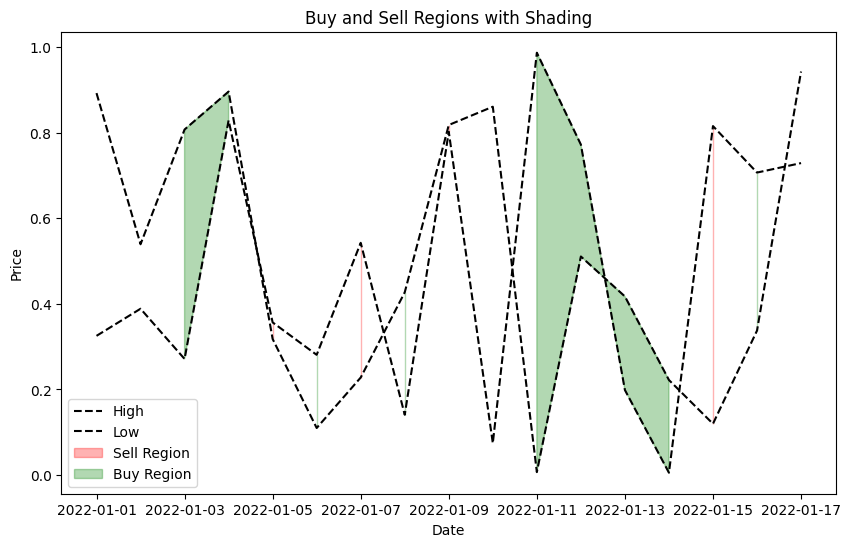

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your DataFrame
data = {
    'Date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05',
             '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09', '2022-01-10',
             '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17'],
    'Open': [0.374540, 0.950714, 0.731994, 0.598658, 0.156019, 0.155995, 0.058084, 0.866176, 0.601115, 0.708073, 0.020584, 0.969910, 0.832443, 0.212339, 0.181825, 0.183405, 0.304242],
    'High': [0.325330, 0.388677, 0.271349, 0.828738, 0.356753, 0.280935, 0.542696, 0.140924, 0.802197, 0.074551, 0.986887, 0.772245, 0.198716, 0.005522, 0.815461, 0.706857, 0.729007],
    'Low': [0.892559, 0.539342, 0.807440, 0.896091, 0.318003, 0.110052, 0.227935, 0.427108, 0.818015, 0.860731, 0.006952, 0.510747, 0.417411, 0.222108, 0.119865, 0.337615, 0.942910],
    'Close': [0.386735, 0.936730, 0.137521, 0.341066, 0.113474, 0.924694, 0.877339, 0.257942, 0.659984, 0.817222, 0.555201, 0.529651, 0.241852, 0.093103, 0.897216, 0.900418, 0.633101],
    'Predicted': [2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot candlestick chart
ax.plot(df['Date'], df['High'], color='black', label='High', linestyle='--')
ax.plot(df['Date'], df['Low'], color='black', label='Low', linestyle='--')
ax.fill_between(df['Date'], df['Low'], df['High'], where=df['Predicted'] == 1, color='red', alpha=0.3, label='Sell Region')
ax.fill_between(df['Date'], df['Low'], df['High'], where=df['Predicted'] == 0, color='green', alpha=0.3, label='Buy Region')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Buy and Sell Regions with Shading')

# Add legend
ax.legend()

# Display the plot
plt.show()


In [13]:
import plotly.graph_objects as go
import pandas as pd

# Your DataFrame
data = {
    'Date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05',
             '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09', '2022-01-10',
             '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17'],
    'Open': [0.374540, 0.950714, 0.731994, 0.598658, 0.156019, 0.155995, 0.058084, 0.866176, 0.601115, 0.708073, 0.020584, 0.969910, 0.832443, 0.212339, 0.181825, 0.183405, 0.304242],
    'High': [0.325330, 0.388677, 0.271349, 0.828738, 0.356753, 0.280935, 0.542696, 0.140924, 0.802197, 0.074551, 0.986887, 0.772245, 0.198716, 0.005522, 0.815461, 0.706857, 0.729007],
    'Low': [0.892559, 0.539342, 0.807440, 0.896091, 0.318003, 0.110052, 0.227935, 0.427108, 0.818015, 0.860731, 0.006952, 0.510747, 0.417411, 0.222108, 0.119865, 0.337615, 0.942910],
    'Close': [0.386735, 0.936730, 0.137521, 0.341066, 0.113474, 0.924694, 0.877339, 0.257942, 0.659984, 0.817222, 0.555201, 0.529651, 0.241852, 0.093103, 0.897216, 0.900418, 0.633101],
    'Predicted': [2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Create candlestick trace
candlestick = go.Candlestick(x=df['Date'],
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'],
                             name='Candlestick')

# Create buy and sell regions
buy_region = go.Scatter(x=df['Date'][df['Predicted'] == 1],
                        y=df['High'][df['Predicted'] == 1],
                        mode='markers',
                        marker=dict(color='green', size=8),
                        name='Buy Region')

sell_region = go.Scatter(x=df['Date'][df['Predicted'] == 2],
                         y=df['High'][df['Predicted'] == 2],
                         mode='markers',
                         marker=dict(color='red', size=8),
                         name='Sell Region')

# Layout
layout = go.Layout(title='Candlestick Chart with Buy/Sell Regions',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price'))

# Create figure
fig = go.Figure(data=[candlestick, buy_region, sell_region], layout=layout)

# Show the plot
fig.show()


In [14]:
import plotly.graph_objects as go
import pandas as pd

# Your DataFrame
data = {
    'Date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05',
             '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09', '2022-01-10',
             '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17'],
    'Open': [0.374540, 0.950714, 0.731994, 0.598658, 0.156019, 0.155995, 0.058084, 0.866176, 0.601115, 0.708073, 0.020584, 0.969910, 0.832443, 0.212339, 0.181825, 0.183405, 0.304242],
    'High': [0.325330, 0.388677, 0.271349, 0.828738, 0.356753, 0.280935, 0.542696, 0.140924, 0.802197, 0.074551, 0.986887, 0.772245, 0.198716, 0.005522, 0.815461, 0.706857, 0.729007],
    'Low': [0.892559, 0.539342, 0.807440, 0.896091, 0.318003, 0.110052, 0.227935, 0.427108, 0.818015, 0.860731, 0.006952, 0.510747, 0.417411, 0.222108, 0.119865, 0.337615, 0.942910],
    'Close': [0.386735, 0.936730, 0.137521, 0.341066, 0.113474, 0.924694, 0.877339, 0.257942, 0.659984, 0.817222, 0.555201, 0.529651, 0.241852, 0.093103, 0.897216, 0.900418, 0.633101],
    'Predicted': [2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Create close price trace
close_trace = go.Scatter(x=df['Date'],
                         y=df['Close'],
                         mode='lines',
                         name='Close Price')

# Create buy and sell regions
buy_region = go.Scatter(x=df['Date'][df['Predicted'] == 1],
                        y=df['Close'][df['Predicted'] == 1],
                        mode='markers',
                        marker=dict(color='green', size=8),
                        name='Buy Region')

sell_region = go.Scatter(x=df['Date'][df['Predicted'] == 2],
                         y=df['Close'][df['Predicted'] == 2],
                         mode='markers',
                         marker=dict(color='red', size=8),
                         name='Sell Region')

# Layout
layout = go.Layout(title='Close Price with Buy/Sell Regions',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Close Price'))

# Create figure
fig = go.Figure(data=[close_trace, buy_region, sell_region], layout=layout)

# Show the plot
fig.show()


[(1191, 582.1), (1166, 581.5), (1131, 580.0), (1014, 749.5), (945, 740.0)]
[(1202, 649.0), (1163, 606.0), (1134, 629.0), (1055, 888.0), (953, 895.0)]


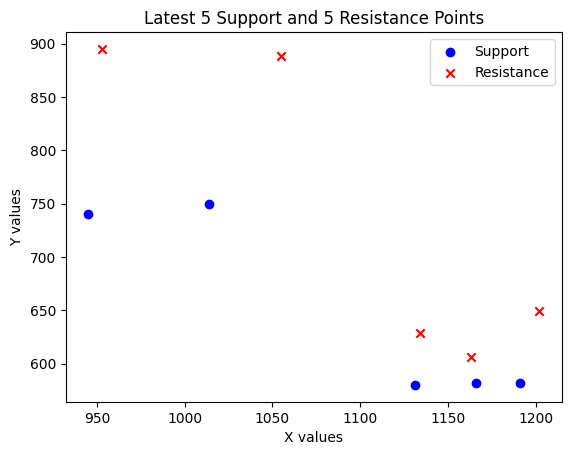

In [2]:
import matplotlib.pyplot as plt

support_points = [(80, 449.04), (222, 341.41), (302, 392.47), (356, 371.44), (401, 361.94), (542, 481.62), (639, 901.95), (705, 961.83), (755, 1038.92), (818, 1022.53), (945, 740.0), (1014, 749.5), (1131, 580.0), (1166, 581.5), (1191, 582.1)]
resistance_points = [(109, 485.58), (111, 485.58), (256, 441.03), (310, 413.0), (436, 428.35), (465, 535.45), (523, 495.07), (623, 1041.17), (658, 1032.93), (694, 995.51), (742, 1136.98), (793, 1237.28), (842, 1190.0), (953, 895.0), (1055, 888.0), (1134, 629.0), (1163, 606.0), (1202, 649.0)]

# Sort the support and resistance points based on the x values
latest_support = sorted(support_points, key=lambda x: x[0], reverse=True)[:5]
latest_resistance = sorted(resistance_points, key=lambda x: x[0], reverse=True)[:5]
print(latest_support)
print(latest_resistance)

# Unpack the x and y values for plotting
support_x, support_y = zip(*latest_support)
resistance_x, resistance_y = zip(*latest_resistance)


# Plot the support and resistance points
plt.scatter(support_x, support_y, marker='o', label='Support', color='blue')
plt.scatter(resistance_x, resistance_y, marker='x', label='Resistance', color='red')

# Add labels and legend
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Latest 5 Support and 5 Resistance Points')
plt.legend()

# Show the plot
plt.show()